In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import log as ln
from scipy.stats import poisson as ps
import statsmodels.api as sm  #subpackage to run simple regressions - there are many more
import statsmodels.tsa as ts
import statsmodels.formula.api as smf
import patsy
from linearmodels import PanelOLS
import warnings
warnings.filterwarnings("ignore")

In [2]:
 
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import sys
import pylab as p
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
# Read in data #
master_data = pd.read_excel('/Users/gbhale/Dropbox/Climate - general/FoodClimate/FCforPython_geo.xlsx',sheet_name='Python',keep_default_na=True)
master_data.columns
#master_data.head

Index(['Year', 'CulturedRS', 'PlantRS', 'CulturedPB', 'PlantPB',
       'Totalcalories', 'Hccalories'],
      dtype='object')

In [19]:
# Parameters #

# Adoption curve parameters for Gompertz #
final_adoption = 1  # converge to.. 1 = 100% #
delta = 2 # years till start #
t0 = 2026 # equivalency point #
altnow = 0.02 # 2% of each type of animal food is now alt #
pbrs = 1  #1 for mostly plant based, 0 for rapid shift - can take on values between 0 and 1#
budget = 390  # cumulative food CO2e budget #

In [20]:
# Vectors #

# PL: 0 1 2 3 4 5 AB:  6 7 8 9 PB:  10 11 12 13 #
foodgroup = ['sugar', 'fat', 'frveg', 'starch', 'pulse',   'cereal', 'egg', 'dairy',  'meat', 'fish', 'pbegg', 'pbdairy', 'pbmeat', 'cultmeat']
# protein per calorie
gprotperkcal = [0,0,0.0327,0.0198,0.0635,0.0305,0.0771,0.0556,0.0750,0.1290,0.0411,0.0355,0.0443,0.0694] 
# Adoption rate
alpha = [0,0,0,0,0,0,0,0,0,0,0.46,0.73,0.18,0.18] # 0.18 alt meat, 0.46 eggs, 0.73 dairy #
# emissions #
e_per100g   = [0,0, 5.4, 7.2, 0.6, 3.5,4.2,9.7,13.6,7.2,1.6,1.8,1.6,2.5]
e_per1000kc = [0.7,0.5,1.2,1.0,0.4,0.8,3.2,5.4,9.9,9.5,0.7,0.7,0.8,1.2]
share2020 = [0.080,0.156,0.069,0.058,0.0458, 0.024, 0.011,0.053,0.082, 0.010,0,0,0,0]    
bau_share2050  = [0.060,0.240, 0.060, 0.030, 0.013, 0.286, 0.020,0.098,0.116,0.015,0,0,0,0]  
hc_share2050 = [0.080,0.1551, 0.0691, 0.0573, 0.0241, 0.4558, 0.008,0.061,0.074,0.016,0,0,0,0]   
plantonly_share2050 = [0.095,0.184,0.082,0.068,0.0291,0.542,0,0,0,0,0,0,0,0]  

pbshare = master_data.PlantPB * pbrs + master_data.PlantRS * (1-pbrs)

totalcal =  np.array(master_data.Totalcalories)
hccal = np.array(master_data.Hccalories)
year =  np.array(master_data.Year).T
T = len(year)

## This is for linear growth in these shares over time, not Gompertz. ##
bau = np.zeros((14,T))
hcs = np.zeros((14,T))
pl = np.zeros((14,T))
for fg in range(0,13,1):
    for t in range(0,T,1):
        bau[fg,t] = share2020[fg]+t*(bau_share2050[fg]-share2020[fg])/(T-1)
        hcs[fg,t] = share2020[fg]+t*(hc_share2050[fg]-share2020[fg])/(T-1)
        pl[fg,t] = share2020[fg]+t*(plantonly_share2050[fg]-share2020[fg])/(T-1)
baushare = bau.T
hcshare  = hcs.T
pltshare = pl.T
fishmeat = np.add(baushare[:,8],baushare[:,9])


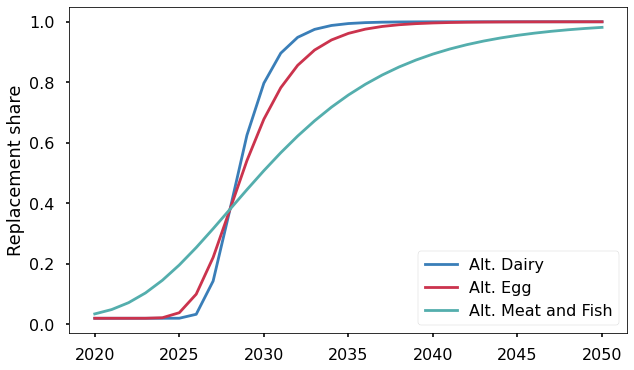

In [21]:
# Gompertz transition to alternatives #
altegg   = altnow + (final_adoption - altnow) * (math.e**(- math.e**(-alpha[10]*(year-(t0+delta)))))
altdairy = altnow + (final_adoption - altnow) * (math.e**(- math.e**(-alpha[11]*(year-(t0+delta)))))
pbmeat   = (altnow + (final_adoption - altnow) * (math.e**(- math.e**(-alpha[12]*(year-(t0+delta))))))  * pbshare 
cultmeat = (altnow + (final_adoption - altnow) * (math.e**(- math.e**(-alpha[12]*(year-(t0+delta))))))  * (1-pbshare) 
sugar  = baushare[:,0]
fat =    baushare[:,1]
frveg  = baushare[:,2]
starch = baushare[:,3]
pulse =  baushare[:,4]
cereal = baushare[:,5]
egg =    baushare[:,6]*(1 - altegg)
dairy =  baushare[:,7]*(1 - altdairy)
meat =   baushare[:,8]*(1 - (pbmeat+cultmeat)*baushare[:,8]/fishmeat)
fish =   baushare[:,9]*(1 - (pbmeat+cultmeat)*baushare[:,9]/fishmeat)
aegg =   baushare[:,6]*altegg
adairy = baushare[:,7]*altdairy
pameat = fishmeat*pbmeat 
cameat = fishmeat*cultmeat
altshare = np.array([sugar,fat,frveg,starch,pulse,cereal,egg,dairy,fish,meat,aegg,adairy,pameat,cameat]).T

## Same for healthy calories and all plant - use fast adoption like dairy for HC and slow like meat for PLT ##
hcsg = np.zeros((14,T))
pltg = np.zeros((14,T))
for fg in range(0,13,1):
    hcsg[fg] = share2020[fg]+(hc_share2050[fg]-share2020[fg])*(math.e**(- math.e**(-alpha[11]*(year-(t0+delta)))))
    pltg[fg] = share2020[fg]+(plantonly_share2050[fg]-share2020[fg])*(math.e**(- math.e**(-alpha[12]*(year-(t0+delta))))) 
hcshareg  = hcsg.T
pltshareg = pltg.T

# Plot gompertz curves

plt.style.use('seaborn-v0_8-poster') # Set style
df = pd.DataFrame({
    'x': year,
    'AltEgg'           : altegg.T,
   'Alt. Dairy'         : altdairy.T,
   'Alt. Meat and Fish'   :  pbmeat.T + cultmeat.T,
})

df.head

#'#cb334d', '#e95c47', '#f98e52', '#fdbf6f', '#fee593', '#ffffbe', '#eaf79e', '#bfe5a0', '#86cfa5',

plt.figure(figsize=(10, 6))  # Set figure size
sns.lineplot(data=df, x='x', y='Alt. Dairy'         , label='Alt. Dairy'   , color='#3a7eb8'      )
sns.lineplot(data=df, x='x', y='AltEgg', label='Alt. Egg', color='#cb334d')
sns.lineplot(data=df, x='x', y='Alt. Meat and Fish'   , label='Alt. Meat and Fish' , color=  '#54aead' )

# Set labels and title
plt.xlabel('')
plt.ylabel('Replacement share')
 
plt.savefig('gcurves.pdf') 



['638.59', '467.90', '500.40', '315.97', '372.60', '309.63', '350.23', '431.96', '341.32']
bau hc hcg alt plt pltg altprot pltprot pltgprot


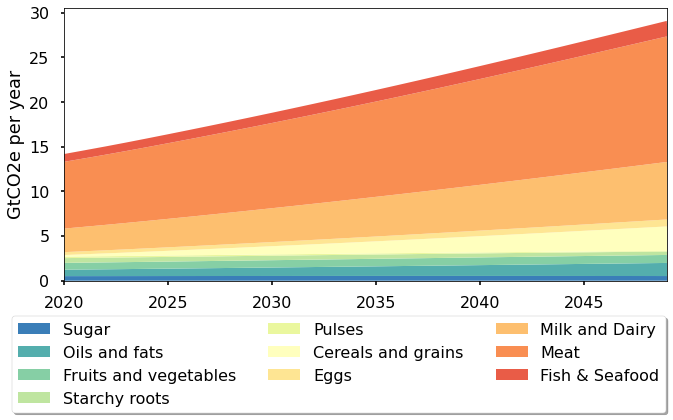

In [18]:
# how much protein per category in bau given totacval
protein = np.zeros((T,14))
altprotein = np.zeros((T,14))
pltprotein = np.zeros((T,14))
pltproteing= np.zeros((T,14))
for fg in range(0,13,1):
     for t in range(0,T-1,1):
            protein[t,fg] =  baushare[t,fg]*totalcal[t]*gprotperkcal[fg]
            altprotein[t,fg] =  altshare[t,fg]*totalcal[t]*gprotperkcal[fg]
            pltprotein[t,fg] =  pltshare[t,fg]*totalcal[t]*gprotperkcal[fg]
            pltproteing[t,fg] = pltshareg[t,fg]*totalcal[t]*gprotperkcal[fg]
totprot = protein.sum(axis=1)
altprot = altprotein.sum(axis=1)
pltprot = pltprotein.sum(axis=1)
pltprotg= pltproteing.sum(axis=1)

# Emissions in scenarios #
emical_alt = np.zeros((T,14))
emical_bau =np.zeros((T,14))
emical_hc  = np.zeros((T,14))
emical_hcg  = np.zeros((T,14))
emiprot_alt = np.zeros((T,14))
emical_plt = np.zeros((T,14))
emiprot_plt = np.zeros((T,14))
emical_pltg = np.zeros((T,14))
emiprot_pltg = np.zeros((T,14))

for fg in range(0,13,1): 
    for t in range(0,T-1,1):
        emical_alt[t,fg] = altshare[t,fg]*e_per1000kc[fg]*totalcal[t]/1000000
        emical_bau[t,fg] = baushare[t,fg]*e_per1000kc[fg]*totalcal[t]/1000000
        emical_hc[t,fg]  = hcshare[t,fg]*e_per1000kc[fg]*hccal[t]/1000000
        emical_hcg[t,fg] = hcshareg[t,fg]*e_per1000kc[fg]*hccal[t]/1000000
        emical_plt[t,fg] = pltshare[t,fg]*e_per1000kc[fg]*totalcal[t]/1000000
        emiprot_alt[t,fg]= altshare[t,fg]*e_per1000kc[fg]*totalcal[t]*(totprot[t]/altprot[t])/1000000
        emiprot_plt[t,fg]= pltshare[t,fg]*e_per1000kc[fg]*totalcal[t]*(totprot[t]/pltprot[t])/1000000
        emical_pltg[t,fg] = pltshareg[t,fg]*e_per1000kc[fg]*totalcal[t]/1000000
        emiprot_pltg[t,fg]= pltshareg[t,fg]*e_per1000kc[fg]*totalcal[t]*(totprot[t]/pltprotg[t])/1000000

emissions =  [np.sum(emical_bau),np.sum(emical_hc),np.sum(emical_hcg),np.sum(emical_alt),np.sum(emical_plt),np.sum(emical_pltg),np.sum(emiprot_alt),np.sum(emiprot_plt),np.sum(emiprot_pltg)]    
    
print(['{:.2f}'.format(item) for item in emissions])
print("bau", "hc", "hcg", "alt", "plt", "pltg", "altprot", "pltprot", "pltgprot",)

# Plot BAU emissions - sum area contribution by food group

 
ccc = (['#cb334d', '#e95c47', '#f98e52', '#fdbf6f', '#fee593', '#ffffbe', '#eaf79e', '#bfe5a0', '#86cfa5', '#54aead', '#3a7eb8'])
ccolors = reversed(ccc)
#.reverse() 
food = (['Sugar', 'Oils and fats', 'Fruits and vegetables',
       'Starchy roots', 'Pulses', 'Cereals and grains', 'Eggs',
       'Milk and Dairy', 'Meat', 'Fish & Seafood'])

plt.style.use('seaborn-v0_8-poster')
#plt.style.use('seaborn-v0_8') # Set style
plt.figure(figsize=(10, 6))  # Set figure size
plt.stackplot(year,emical_bau.T,colors=ccolors)
plt.legend(loc='upper left',labels=food, bbox_to_anchor=(-0.1, -0.1),fancybox=True, shadow=True, ncol=3)
plt.tight_layout()
plt.xlim(2020,2049)
plt.ylabel('GtCO2e per year')
#plt.show()    
plt.savefig('BAU.pdf',bbox_inches="tight")     

 


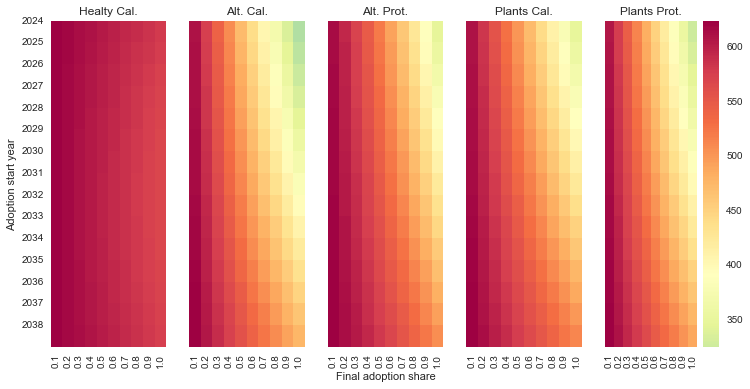

In [11]:
# start year, final adoption #
em_alt_cal  = np.zeros((15,10))
em_alt_prot = np.zeros((15,10))
em_hc = np.zeros((15,10))
em_plt_cal = np.zeros((15,10))
em_plt_prot = np.zeros((15,10))
em_bau = np.zeros((15,10))
falist = np.zeros((10))
sylist = np.zeros((15))

delta = 0 # years till start #
altnow = 0.02 # 2% of each type of animal food is now alt #
pbrs = 0  #1 for mostly plant based, 0 for rapid shift - can take on values between 0 and 1#
budget = 390  # cumulative food CO2e budget #

for ffa in range(0,10,1):
    falist[ffa]=round(0.1+ffa/10,2)
    for ssy in range(0,15,1):
        sylist[ssy]=round(2024+ssy,0)
        fa = 0.1+ffa/10
        sy = 2024+ssy
        altegg   = altnow + (fa - altnow) * (math.e**(- math.e**(-alpha[10]*(year-(sy+delta)))))
        altdairy = altnow + (fa - altnow) * (math.e**(- math.e**(-alpha[11]*(year-(sy+delta)))))
        pbmeat   = (altnow + (fa - altnow) * (math.e**(- math.e**(-alpha[12]*(year-(sy+delta))))))  * pbshare 
        cultmeat = (altnow + (fa - altnow) * (math.e**(- math.e**(-alpha[12]*(year-(sy+delta))))))  * (1-pbshare) 
        sugar  = baushare[:,0]
        fat =    baushare[:,1]
        frveg  = baushare[:,2]
        starch = baushare[:,3]
        pulse =  baushare[:,4]
        cereal = baushare[:,5]
        egg =    baushare[:,6]*(1 - altegg)
        dairy =  baushare[:,7]*(1 - altdairy)
        meat =   baushare[:,8]*(1 - (pbmeat+cultmeat)*baushare[:,8]/fishmeat)
        fish =   baushare[:,9]*(1 - (pbmeat+cultmeat)*baushare[:,9]/fishmeat)
        aegg =   baushare[:,6]*altegg
        adairy = baushare[:,7]*altdairy
        pameat = fishmeat*pbmeat 
        cameat = fishmeat*cultmeat
        altshare = np.array([sugar,fat,frveg,starch,pulse,cereal,egg,dairy,fish,meat,aegg,adairy,pameat,cameat]).T
        fast = fa*(math.e**(- math.e**(-alpha[11]*(year-(sy+delta)))))
        slow = fa*(math.e**(- math.e**(-alpha[12]*(year-(sy+delta)))))
        for fg in range(0,13,1):
            hcsg[fg] = baushare[:,fg]*(1-fast)+hc_share2050[fg]*fast
            pltg[fg] = baushare[:,fg]*(1-slow)+plantonly_share2050[fg]*slow
        hcshareg  = hcsg.T
        pltshareg = pltg.T
                                      
        protein = np.zeros((T,14))
        altprotein = np.zeros((T,14))
        pltproteing = np.zeros((T,14))
        for fg in range(0,13,1):
            for t in range(0,T-1,1):
                protein[t,fg] =  baushare[t,fg]*totalcal[t]*gprotperkcal[fg]
                altprotein[t,fg] =  altshare[t,fg]*totalcal[t]*gprotperkcal[fg]
                pltproteing[t,fg] = pltshareg[t,fg]*totalcal[t]*gprotperkcal[fg]
        totprot = protein.sum(axis=1)
        altprot = altprotein.sum(axis=1)
        pltprotg= pltproteing.sum(axis=1)    
        
        emi_bau = np.zeros((T,14))
        emical_alt = np.zeros((T,14))
        emiprot_alt = np.zeros((T,14))
        emical_hcg = np.zeros((T,14))
        emical_pltg = np.zeros((T,14))
        emiprot_pltg = np.zeros((T,14))
        for fg in range(0,13,1): 
            for t in range(0,T-1,1):
                emi_bau[t,fg] = baushare[t,fg]*e_per1000kc[fg]*totalcal[t]
                emical_alt[t,fg] = altshare[t,fg]*e_per1000kc[fg]*totalcal[t]
                emical_hcg[t,fg] = hcshareg[t,fg]*e_per1000kc[fg]*hccal[t] 
                emical_pltg[t,fg] = pltshareg[t,fg]*e_per1000kc[fg]*totalcal[t] 
                emiprot_alt[t,fg] = altshare[t,fg]*e_per1000kc[fg]*totalcal[t]*(totprot[t]/altprot[t])
                emiprot_pltg[t,fg]= pltshareg[t,fg]*e_per1000kc[fg]*totalcal[t]*(totprot[t]/pltprotg[t]) 
        tmp0 = np.sum(emi_bau)/1000000
        tmp1 = np.sum(emical_alt)/1000000
        tmp2 = np.sum(emiprot_alt)/1000000
        tmp3 = np.sum(emical_hcg)/1000000
        tmp4 = np.sum(emical_pltg)/1000000
        tmp5 = np.sum(emiprot_pltg)/1000000
        em_alt_cal[ssy,ffa] =   tmp1
        em_alt_prot[ssy,ffa] =  tmp2
        em_hc[ssy,ffa] =  tmp3
        em_plt_cal[ssy,ffa] =  tmp4
        em_plt_prot[ssy,ffa] =  tmp5
        em_bau[ssy,ffa] = tmp0 
        
plt.style.use('seaborn-v0_8') # Set style
fig, (ax1, ax2, ax3, ax4, ax5)  = plt.subplots(nrows=1,ncols=5,figsize=(12,6),sharex=True,sharey=True)

s1= sns.heatmap(em_hc, linewidth = 0 , ax=ax1  ,cbar = False,   cmap = 'Spectral_r', center=budget )
s2= sns.heatmap(em_alt_cal, linewidth = 0 , ax=ax2  ,cbar = False, cmap = 'Spectral_r', center=budget )
s3= sns.heatmap(em_alt_prot, linewidth = 0 , ax=ax3 ,cbar = False ,   cmap = 'Spectral_r', center=budget)
s4= sns.heatmap(em_plt_cal, linewidth = 0 , ax=ax5   ,   cmap = 'Spectral_r', center=budget )
s5= sns.heatmap(em_plt_prot, linewidth = 0 , ax=ax4  ,  cbar = False, cmap = 'Spectral_r', center=budget, cbar_kws={'label': 'Cumulative emissions (GtCO2e)'})

ax1.set_title('Healty Cal.')
ax1.set_ylabel('Adoption start year')
ax1.set_yticks(np.arange(15))
ax1.set_yticklabels(sylist.astype(int), rotation='horizontal')
ax1.set_xticklabels(falist, rotation='vertical')

ax2.set_title('Alt. Cal.')
ax2.set_yticklabels(sylist.astype(int), rotation='horizontal')
ax2.set_xticklabels(falist, rotation='vertical')

ax3.set_title('Alt. Prot.')
ax3.set_yticklabels(sylist.astype(int), rotation='horizontal')
ax3.set_xlabel('Final adoption share')
ax3.set_xticklabels(falist, rotation='vertical')

ax4.set_title('Plants Cal.')
ax4.set_yticklabels(sylist.astype(int), rotation='horizontal')
ax4.set_xticklabels(falist, rotation='vertical')

ax5.set_title('Plants Prot.')
ax5.set_yticklabels(sylist.astype(int), rotation='horizontal')
ax5.set_xticklabels(falist, rotation='vertical')


#plt.savefig('pbrs1delta0.pdf') 
plt.savefig('pbrs0delta0.pdf') 
#plt.savefig('pbrs0delta2.pdf') 
#plt.savefig('pbrs1delta2.pdf') 

#plt.plot([5, 5], [0,4], 'k-', lw=2)
#plt.plot([6, 6], [4,7], 'k-', lw=2)
#plt.plot([7, 7], [7,10], 'k-', lw=2)
#plt.plot([8, 8], [10,12], 'k-', lw=2)
#plt.plot([5, 6], [4,4], 'k-', lw=2)
#plt.plot([6, 7], [7,7], 'k-', lw=2)
#plt.plot([7, 8], [10,10], 'k-', lw=2)
#plt.plot([8, 9], [12,12], 'k-', lw=2)
 